<a href="https://colab.research.google.com/github/neflem27/Algorithmic_Insights-My_Machine_Learning_Library/blob/main/HOMLSKT_Chapter_3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST

This chapter uses the MNIST dataset, which is a dataset composed of 70,000 small images of digits handwriten by high school students and employees of the US Census Bureau. Each image is labeled withe the digit it represents.

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
X.shape # Dimension of Dataset (m x n)

(70000, 784)

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [8]:
y.shape # 70,000 digits

(70000,)

There are 70,000 images in the target variable composed of 784 features. This is because each image is (28 x 28), and **each feature represents one pixel's intensity**, from 0 (white) to 255 (black).

Below is an example of one of the digits.

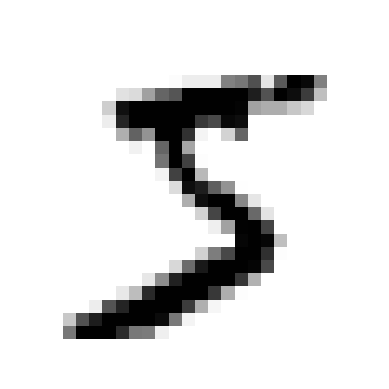

In [9]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28,28)
  plt.imshow(image, cmap = "binary")
  plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [10]:
y[0] # Our target variable confirms that the digit is a 5

'5'

## Test/Training Split

A test/traning split always comes before any further data inspection, in this case our given dataset has by default been splitted into a test set (first 60,000 images) and a training set (last 10,000 images).


In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[:60000], y[:60000], y[60000:]

The traning set is already shuffled for us, which gurantees a balanced cross validation, meaning that each fold should contain each digit.

## Traning a Binary Classifier

Lets try to simplify the problem with an example of a *binary classifier*, capable of identifying between two classes, 5 and non-5. First we'll create the target vectors for this task.

In [12]:
y_train_5 = (y_train== '5')
y_test_5 = (y_test == '5')

Now lets pick a classifier and train it. A good place to start is with a *stochastic gradient descent* (SGD), using Scikit-Learn's **SGDClassifier** class. This classifier is capable of handling very large datasets as it deals with traning instances one at a time.

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5

In [14]:
sgd_clf.predict([some_digit]) # Our classifier correcly guessed that X[0] is 5

array([ True])

## Performance Measures

Evaluating a classifier requires more in depth analysis and this chapter will dedicate a larger part to the topic.

### Measuring Accuracy Using Cross-Validation

Lets use *cross_val_score()* function to evaluate your *SGDClassifier* model using K-fold cross-validation, with three folds. Remember that K-fold cross validation means splitting the traning set into K-folds (in this case 3), then making predictions and evaluating them on each fold using a model trained on the remaining folds.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In this case we have an accuracy of 95% on all cross validation folds. However, this is can be misleading. Lets take a look at a simple classifier that just classifies every single image as a 'non_5'.

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # Prints false when instance is not a 5

False


Lets find out the accuracy of this model

In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv = 3, scoring= "accuracy")

array([0.90965, 0.90965, 0.90965])

This dummy model has over 90% accuracy simply because only about 10% of the images are 5s. This is an example of how a high accuracy is not generally preferred as a performance measure for classifiers.

This problem arises with *skewed datasets* or imbalanced data, meaning that some classes have a much higher frequency than others.

### Confusion Matrix

Confusion matrices are a better way to measure performance. The general idea is to find out how many observations were  classified in the right category.

To compute a confusion matrix first we need a set of predictions so they can be compared to the actual target variable y. We could compute this by comparing our predictions vs our test set, but its better to leave that data untoughed until the end of the project. Instead, we can use the *cross_val_predict()* function:



In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

Just like the *cross_val_score()* the *cross_val_predict()* performs K-fold cross-validation, but instead of returning the evaluation scores, it **returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

Now we can compure our *confusion_matrix()* function:



In [19]:
 from sklearn.metrics import confusion_matrix
 confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

We can further evaluate our matrix via *Precision*.

3.1 $$ Precision = \frac{TP}{TP + FP}$$

TP is the number of true positives, and FP is the number of false positives. Moreover, presicion is typically used along another metric named *recall* (sensitivity) or *true positive rate*

TPR: Ratio of positive instances that were correctly classified by our model.

3.2 $$ Recall = \frac{TP}{TP + FN}$$

FN is the number of false negatives.




### Precision and Recall

ScikitlLearn provides several functions to compute classifier metrics, including precision and recall:


In [20]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Our classifier is only correct 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric called the *F score*. This is useful when comparing two classifiers

The F1 score is the *harmonic mean* of precision and recall. Whereas the regular mean treats values equally, the harmonic mean gives much more weight to low values. As a result, **the classifier will only get a high F if both recall and precision are high**.

3.3 $$ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$$






To compute the F1 score, simply call the *f1_score()* function:

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Tradeoff

To understand this tradeoff, let's look at how the *SGDClassifier* makes its classification decisions. For each instance, it computes a score based on a *decision function*, and if that score is greater than a threshold, it assigns the instance to the positive class, else it gets classified into the negative class. Conversely, lowering the threshold increases recall and reduces precision.

Scikit-Learn does not let you set the threshold directly, but it gives you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s *predict()* method, you can call its *decision_function()* method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want:


The F score favors classifiers that have similar precision and recall. This is not always benefitial.

Example 1:

*YouTube Kids* video classifier will opt for a model with high precision and low recall. Meaning that all selected videos will be safe to watch for kids altough some of the "good videos" might be classified as 18 + and left out.

Example 2:

A classifier to detect and stop  shoplifters. In this case a company will prefer an model with significantly lower precision, lets say 45% with a recall of 99%. This means that security will have more false alarms but most of the shoplifting attemps will be promptly identified.

These examples show how higher precision is not always best. Unfortunately, you can't have it both ways. This is called *precision/recall tradeoff*.

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the *predict()* method (i.e., True). Let’s raise the threshold:

In [25]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 3,000.

How do we decide what threshold to use? For this we need to get the scores of all instances in the traning set using the *cross_val_predict()* function again, but this time specifying that you want to return decision scores instead of predictions:



In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now with these scores we can compute precision and recall **for all possible thresholds** using the *precision_recall_curve()* function:


In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

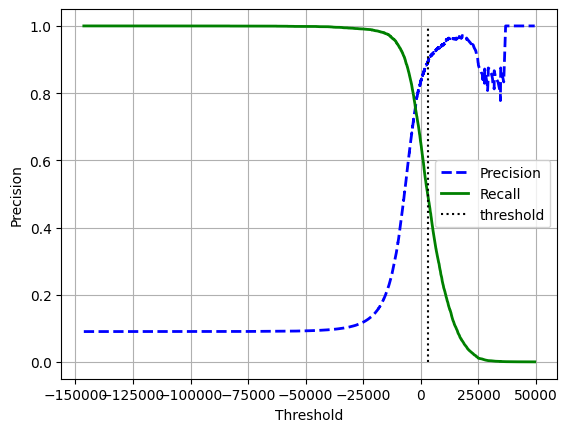

In [28]:
plt.plot(thresholds, precisions[:-1], "b--", label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g-", label = "Recall", linewidth = 2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label = "threshold")
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.legend()
plt.grid()

At this threshold value, precision is near 90% and recall is around 50%. Another way to select a good precision/recall/trade-off is to plot precision directly against recall.

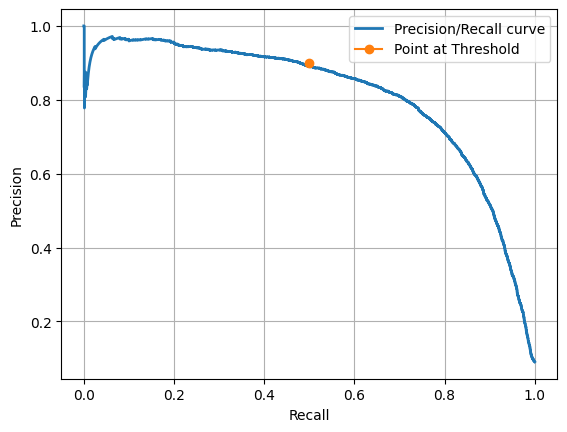

In [29]:
plt.plot(recalls, precisions, linewidth = 2, label = "Precision/Recall curve")
plt.plot(0.5,0.9, marker = "o", label = "Point at Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()

Precision stats to fall sharply after 80% recall. We can use a point before the drop but once again, the cut depends on the goal of your project.

Suppose that you decide to aim for 90% precision. You could use the first plot to find the threshold but its not that efficient. Alternatively, we can search for the lowest threshold that gives 90% precision. For this we use NumPy array's *argmax()* method. This returns the first index of the maximum value, which in this case means the first *True* value:

In [30]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

To make predictions on the traning set instead of using *predict()* we can use this instead:

In [31]:
y_train_pred_90= (y_scores >= threshold_for_90_precision)

Let's check these predictions' precision and recall.

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

### The ROC Curve

The *receiver opening characteristic* (ROC) curve is another common performance measure very similar to the precision/recall curve, but instead of plotting precision vs recall, the ROC curve plots the *true positive rate* (TPR) against the *false positive rate* (FPR). The false potive rate is the ratio of negative instances incorrectly classified as negative. On the othe hand, the *true negative rate* (TNR) is the ratio of negative instances correctly classified as negative. Hence, the ROC plots recall vs 1- TNR.

To plot the ROC curve we first use the *roc_curve()* function to compute the TPR and FPR for various threshold values:


In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then we plot FPR vs TPR using Matplotlib. To find the point that corresponds to 90% precision, we need to look for the index of the desired threshold. Since thresholds are listed in decreasing order in this case, we use <= instead of >= on the first line:

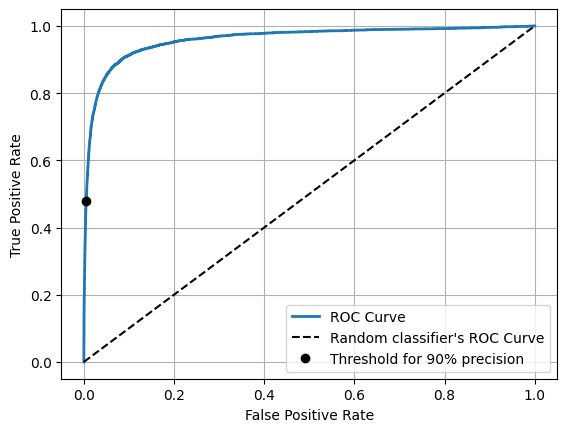

In [35]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier's ROC Curve")
plt.plot([fpr_90], [tpr_90], "ko", label= "Threshold for 90% precision")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).
One way to compare classifiers is to measure the area under the curve (AUC). A per‐
fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:


In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Since the ROC curve and the precision recall curve are very similar, **use the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives**, and the ROC curve otherwise.

Lets now create a *RandomForestClassifier*, whose PR curve ans F1 score can be compared to that of the *SGDClassifier*:



In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

The *precision_recall_curve()* function expect labels and sores for each instance, so we need to train the random forest classifier and make it assgn a score to each instance. But the *RandomForestClassifier* class does not have a *decision_function()* method, due to the way it works. Luckily, it has a *predict_prob()* method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score. We can use the *cross_val_predict()* function to train the *RandomForestClassifier* using the cross-validation and make it predict class probabilities for every image as follows:


In [38]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method="predict_proba")

Let's look at the class probabilities for the first 5 images in the traning set:


In [39]:
y_probas_forest[:5] # Output: [negative prob %, positive prob %]

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.99, 0.01]])

The first image is predicted positive with 89% probability while the second image is classified as negative with 99% probability and so on. Adding each row give you 100%.

The second column contains the estimated probabilities for the positive class, so let's pass them to the *precision_recall_curve()* functions:

In [40]:
y_scores_forest = y_probas_forest[:,1]
precision_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

Now let's plot the PR curve.

Text(0, 0.5, 'Precision')

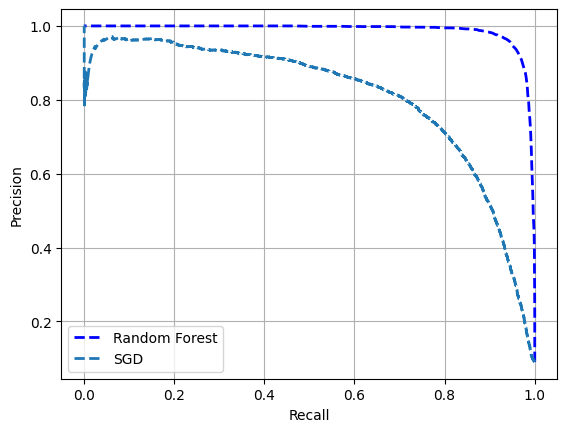

In [41]:
plt.plot(recalls_forest, precision_forest, 'b--', linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label = "SGD")
plt.legend()
plt.grid()
plt.xlabel("Recall")
plt.ylabel("Precision")

In this case, the Random Forest Classifier is superior to our SGD as its PR curve is much closer to the top right, meaning that it has a greater AUC value.

## Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

For example, one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA) strategy (also called one-versus-the-rest).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train **N × (N – 1) / 2** classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐ class classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO). Let’s try this with the SGDClassifier:

In [42]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # Original y variable (0-9)

SVC(random_state=42)

We trained the SVC using the original target classes, instead of the 5-versus-the-rest target classes (*y_train_5*). Since there are 10 classes, Scikit-Learn used the OVO to train 45 binary classifiers. Now lets make a prediction.

In [43]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

The code made 45 predictions (one per pair of classes) and selected the class that won the most duels. If you call the *decision_function()* method, you will see that it returns 10 scores per instance (one per class). Each class gets a score equal to the number of won duels plus or minus a small tweak (max plus or minus 0.33) to break ties, based on classification scores:


In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2) # Greater score is 9.5 which belongs to class 5

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [45]:
class_id = some_digit_scores.argmax()
class_id

5

When a classifier is trained, it stores the list of target classes in its *classes_*attribute, ordered by value.  In the case of MNIST, the index of each class in the *classes_*array conviniently matches the class itself, but in general you won't be so lucky; you will need to look up the class label like this:


In [46]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [47]:
svm_clf.classes_[class_id]

'5'

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the *OneVsOneClassifier* or *OneVsRestClassifier* classes. Simply create an instance and pass a binary classifier to its constructor. For example, this code creates a multiclass classifier using the *OvO* strategy, based on a *SGDClassifier*:

In [48]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

Let's make a prediction, and check the number of trained classifiers.

In [49]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [50]:
len(ovr_clf.estimators_)

10

Training an *SGDClassifier* on a multiclass dataset and using it to make predictions is just easy:


In [51]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

This output is incorrect. Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifiers. The *decision()* function method now returns one value per class. Let's look at the cores that the SGD classifier asssigned to each class.

In [52]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

Here we can see that the classifier is not very confident about its precdiction: almost all scores are very negative, while class 3 has a score of + 1824, anc class 5 -1386. Of course, you'll want to evaluate the classifier on more than one image. Since there are roughly the same number of images in each class, the accuracy metric is fine. As usual, you can use the *cross_val_score()* function to evaluate the model:

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 85% on all test folds. We could do much better by scaling the inputs, giving us a accuracy of 89.1%.


In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
#cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
# Code takes time to render

## Error Analysis

Of course, if this were a real project, you would follow the steps in your Machine Learning project checklist: exploring data preparation options, trying out multiple models, shortlisting the best ones and fine-tuning their hyperparameters using GridSearchCV, and automating as much as possible, as you did in the previous chapter. Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First, you can look at the confusion matrix. You need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function, just like you did earlier. However, since there are now 10 classes instead of 2, the confusion matrix will contain quite a lot of numbers and it may be hard to read.

A colored diagram of the confusion matrix is much easier to analyze. To plot such a diagram, use the *ConfusionMatrixDisplay.from_predictions()* function like this:


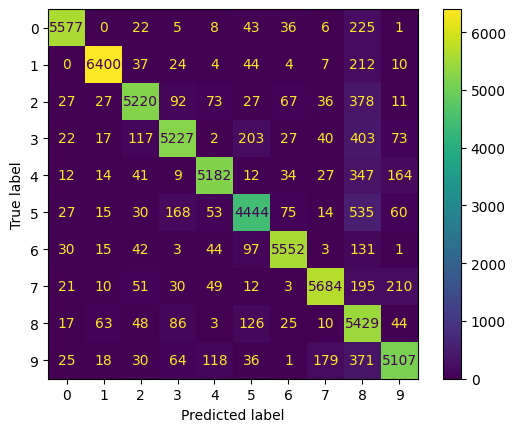

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

This matrix looks pretty good as most images fall on the main diagonal, meaning that they were classified correctly. Notice that the cell on the diagonal in row 5 and column 5 looks slightly darker than the other digits. Thsi could be because the model made more errors on 5's because there are fewer 5's in the dataset than the other digits. That's why it is important to normalize the confusion matrix by dividing each value by the total number of images in the corresponding (true) class. Thsi can be simply done by setting *normalize="true"*. We can also specify the *values_format*= *.0%* argument to show percentages with no decimals.

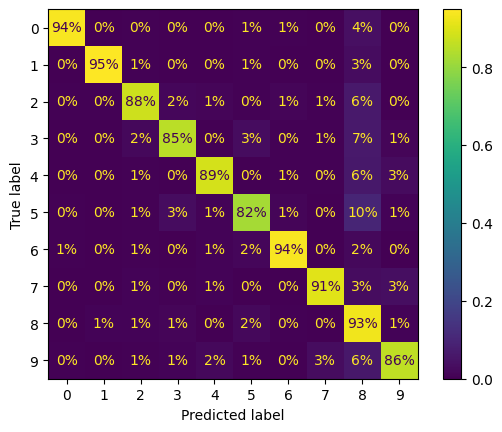

In [63]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")

We can easily see that only 82% of the images of 5s were correctly classified. The most common misclassification error for 5s were treating them as 8s: this happened for 10% of all 5s. But only 2% of 8s got misclassified as 5s.

If you want errors to stand out more, you can try putting zero weight on the correct predictions:

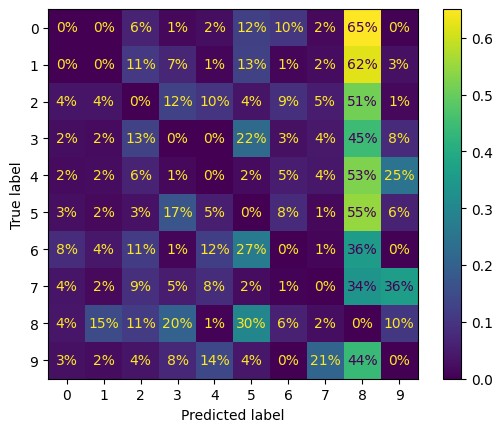

In [60]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")

Now we can see much more clearly the kinds of errors that the classifier makes. The column for class 8 is now really bright, which confirms that many images got misclassified as 8s. In fact, this is the most common misclassification among all classes.

Recall that we have excluded the correct predictions in the previous diagram. For example, the 36% in row 7 column 9 does not mean that 36% of all images of 7s were misclassified as 9s. It means that 36% of the errors that the model made on images of 7s were misclassifications as 9s. In reality, only 3% of images of 7s were misclassified as 9s.

It is also possible to normalize the confusion matrix by column rather than by row: if you set *normalize*=*"pred"*:

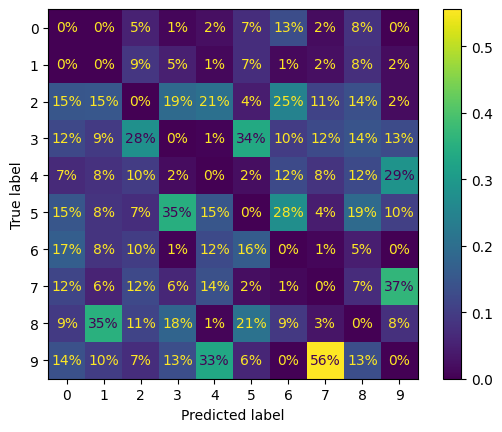

In [62]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%")

We can see that 56% of misclassified 7s are actually 9s

Analyzing the confusion matrix often gives you insights into what ways to improve your classifier. Looking at these plots, it seems that your efforts should be spent on reducing the false 8s. For example, you could try to gather more traning data for the digits that look like 8. Or you could engineer new features to help the classifier-for example, writing al algorithm to count the number of closed loops (e.g. using Scikit-Image, Pillow, or Open CV) to make some patterns, such as closed loops, stand out more.

Analyzing individual errors can also be a good way to gain insights into what way your classifier is doing and why it is failing. For example, let's plot examples of 3s and 5s in a confusion matrix style.

In [66]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]



<ipython-input-66-820a7472455b>:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
<ipython-input-66-820a7472455b>:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
<ipython-input-66-820a7472455b>:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
<ipython-input-66-820a7472455b>:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
